In [1]:
import hashlib
import numpy as np
import os
import pandas as pd
import multiprocessing
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

In [2]:
SPLITS_ID = 3

In [3]:
DATASET_PATH = "/kaggle/input/data-car-public/Public"

In [4]:
BATCH_SIZE = 64
WIDTH = 224
HEIGHT = 224
SEED = 42

In [5]:
## DATA LOADING
#Tạo đường dẫn đến file train và test theo SPLITS_ID
train_csv = '/kaggle/input/cardataset-splits/CarDataset-Splits-3-Train.csv'
test_csv = '/kaggle/input/cardataset-splits/CarDataset-Splits-3-Test.csv'

#Đọc file
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

#Cập nhật cột file_path trong DataFrame train_df, test_df bằng cách thêm đường dẫn cơ sở (DATASET_PATH) vào mỗi giá trị trong cột này
train_df["ImageFullPath"] = train_df["ImageFullPath"].apply(lambda x: os.path.join(DATASET_PATH, x))
test_df["ImageFullPath"] = test_df["ImageFullPath"].apply(lambda x: os.path.join(DATASET_PATH, x))

#Chuyển kiểu dữ liệua các gía trị trong cột class sang dạng string vì flow_from_dataframe cần đầu vào là kiểu string
train_df["CategoryID"] = train_df["CategoryID"].astype(str)
test_df["CategoryID"] = test_df["CategoryID"].astype(str)

In [6]:
train_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
27858,/kaggle/input/data-car-public/Public/Honda/225...,1
27859,/kaggle/input/data-car-public/Public/Honda/225...,1
27860,/kaggle/input/data-car-public/Public/Honda/225...,1
27861,/kaggle/input/data-car-public/Public/Honda/225...,1


In [7]:
test_df

,ImageFullPath,CategoryID
0,/kaggle/input/data-car-public/Public/Mazda/225...,4
1,/kaggle/input/data-car-public/Public/Mazda/225...,4
2,/kaggle/input/data-car-public/Public/Mazda/225...,4
3,/kaggle/input/data-car-public/Public/Mazda/225...,4
4,/kaggle/input/data-car-public/Public/Mazda/225...,4
...,...,...
6961,/kaggle/input/data-car-public/Public/Honda/225...,1
6962,/kaggle/input/data-car-public/Public/Honda/225...,1
6963,/kaggle/input/data-car-public/Public/Honda/225...,1
6964,/kaggle/input/data-car-public/Public/Honda/225...,1


In [8]:
## PREPROCESSING

image_set = set()
#Tạo 1 set dùng để lưu trữ các giá trị hash của các mảng numpy đại diện cho ảnh. Điều này giúp phát hiện các ảnh trùng lặp.

def hash_numpy_array(arr):
    '''
    Mục đích: Tạo giá trị hash từ một mảng numpy để kiểm tra trùng lặp ảnh.
    '''
    arr_bytes = arr.tobytes()
    #Chuyển đổi mảng numpy thành chuỗi bytes.

    hash_obj = hashlib.sha256(arr_bytes)
    #Tạo đối tượng hash SHA-256 từ chuỗi bytes.

    hash_hex = hash_obj.hexdigest()
    #Chuyển đổi đối tượng hash thành chuỗi hex.

    return hash_hex
    #Trả về chuỗi hex của giá trị hash.

def validate_image(image_path, skip_duplicate):
    '''
    Mục đích: Xác thực một ảnh.
    Cách hoạt động:
        - Kiểm tra xem đường dẫn ảnh có tồn tại và là một tệp tin không.
        - Mở ảnh và thay đổi kích thước.
        - Nếu skip_duplicate là True, tính toán giá trị hash của ảnh và kiểm tra xem giá trị này đã có trong image_set chưa.
            + Nếu đã có, trả về False.
            + Nếu chưa, thêm giá trị hash vào image_set.
        - Trả về True nếu ảnh hợp lệ.
    '''
    if not os.path.exists(image_path):
        return False
    if not os.path.isfile(image_path):
        return False
    try:
        with Image.open(image_path) as img:
            img.resize((WIDTH, HEIGHT))
            if skip_duplicate:
                hash_value = hash_numpy_array(np.array(img))
                if hash_value in image_set:
                    return False
                else:
                    image_set.add(hash_value)
        return True

    except Exception as e:
        print(e)
        return False

def validate_images_multicore(df, num_processes, skip_duplicate=False):
    '''
    Mục đích: Xác thực các ảnh trong DataFrame bằng cách sử dụng nhiều tiến trình.
    Cách hoạt động:
        - multiprocessing.Pool(num_processes): Tạo một pool với số lượng tiến trình được chỉ định bởi num_processes.
        - pool.starmap(validate_image,
                       zip(df["file_path"],
                       [skip_duplicate] * len(df))
                       ): Phân chia công việc xác thực ảnh giữa các tiến trình.
        - zip(df["file_path"],
              [skip_duplicate] * len(df)
              ): Kết hợp từng đường dẫn ảnh với giá trị skip_duplicate để truyền vào hàm validate_image.
        - return df[results]: Trả về DataFrame chỉ chứa các hàng mà ảnh đã được xác thực hợp lệ.
    '''
    with multiprocessing.Pool(num_processes) as pool:
        results = pool.starmap(
            validate_image,
            zip(df["ImageFullPath"], [skip_duplicate] * len(df))
        )
    return df[results]

In [9]:
train_df = validate_images_multicore(train_df, num_processes=16, skip_duplicate=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


cannot identify image file '/kaggle/input/data-car-public/Public/Mitsubishi/22521463-22521213-22521259.Mitsubishi.57.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Mitsubishi/22521463-22521213-22521259.Mitsubishi.75.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Mitsubishi/22521463-22521213-22521259.Mitsubishi.76.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Others/22521463-22521213-22521259.Others.53.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Others/22520477-22520490.Others.7.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Others/22520477-22520490.Others.8.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Others/22520477-22520490.Others.2.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Others/22520477-22520490.Others.30.jpg'
cannot identify image file '/kaggle/input/data-car-public/Public/Others/22520477-22520490.Others.6.jpg'

In [10]:
image_set = set()

In [11]:
test_df = validate_images_multicore(test_df, num_processes=16)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [12]:
## TRAINING
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # Xoay ảnh trong khoảng [-20, 20] độ
    width_shift_range=0.2,  # Dịch chuyển ngang
    height_shift_range=0.2,  # Dịch chuyển dọc
    shear_range=0.2,  # Biến đổi hình dạng
    zoom_range=0.2,  # Phóng to/thu nhỏ
    horizontal_flip=True,  # Lật ngang
    fill_mode='nearest'  # Điền giá trị vào các vùng bị thay đổi
)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

dataframe_config = {
    'x_col': 'ImageFullPath',
    'y_col': 'CategoryID',
    'target_size': (HEIGHT, WIDTH),
    'batch_size': BATCH_SIZE,
    'class_mode': 'categorical',
    'shuffle': True,
    'seed': SEED,
    'color_mode': 'rgb',
}

train_generator = train_data_generator.flow_from_dataframe(train_df, **dataframe_config)
test_generator = test_data_generator.flow_from_dataframe(test_df, **dataframe_config)


Found 27509 validated image filenames belonging to 9 classes.
Found 6956 validated image filenames belonging to 9 classes.


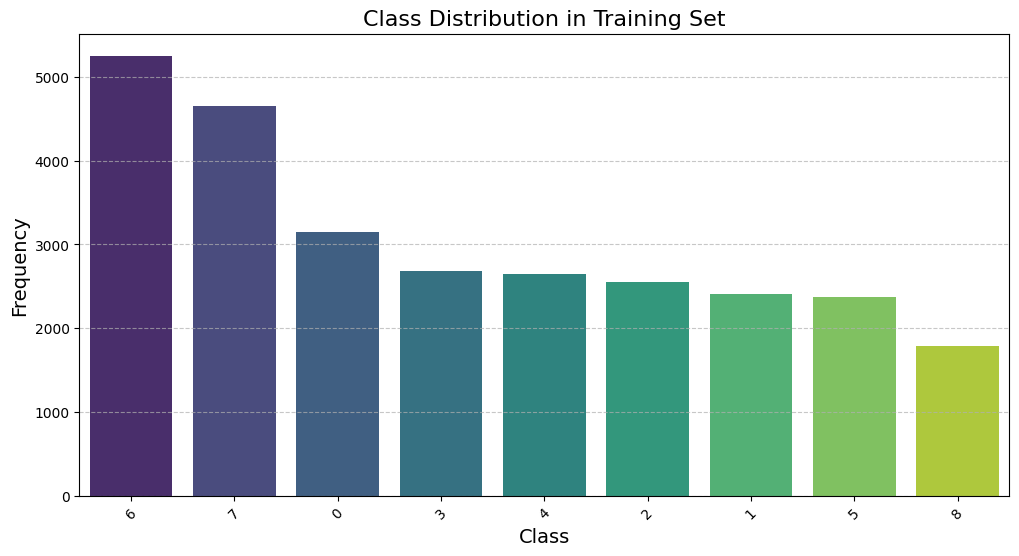

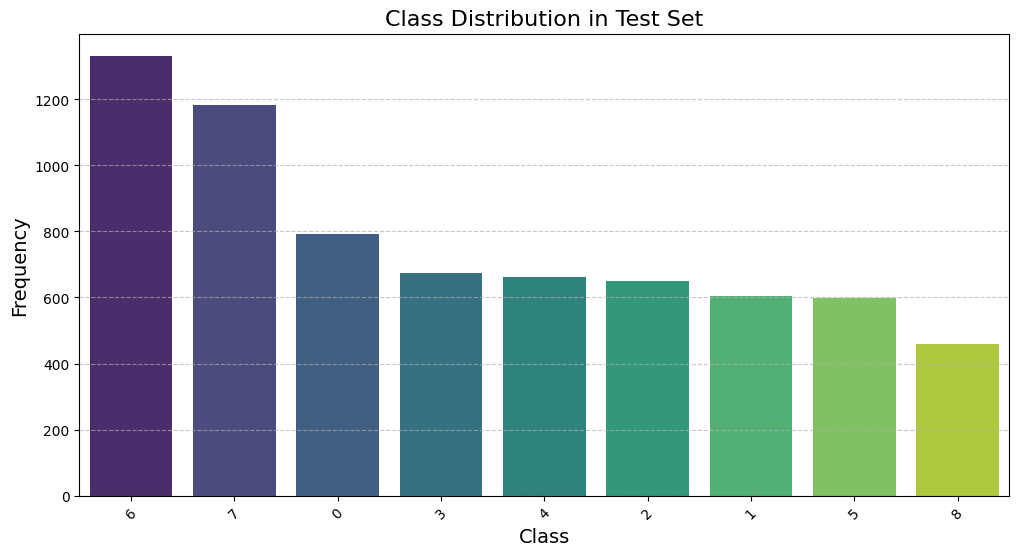

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, title, column='CategoryID'):
    """
    Vẽ biểu đồ phân phối dữ liệu của các lớp.
    df: DataFrame chứa dữ liệu.
    title: Tiêu đề biểu đồ.
    column: Cột chứa thông tin phân loại.
    """
    class_counts = df[column].value_counts()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Kiểm tra phân phối dữ liệu trong tập huấn luyện và tập kiểm tra
plot_class_distribution(train_df, title="Class Distribution in Training Set")
plot_class_distribution(test_df, title="Class Distribution in Test Set")


In [14]:
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, 3))


# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(train_df['CategoryID'].unique()), activation='softmax')  # Adjust output neurons
])

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
learning_rate = 0.0001
epochs = 30

In [16]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler

# Callbacks
checkpoint = ModelCheckpoint("model.keras", monitor="loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="loss", patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

callbacks = [checkpoint, early_stopping, reduce_lr]


In [18]:
# Xử lý class imbalance (nếu có)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['CategoryID']),
    y=train_df['CategoryID']
)

class_weights_dict = dict(enumerate(class_weights))


In [19]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=None,
    callbacks=callbacks,
    class_weight=class_weights_dict 
)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2213 - loss: 2.5200
Epoch 1: loss improved from inf to 2.24191, saving model to model.keras
430/430 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - accuracy: 0.2214 - loss: 2.5194 - learning_rate: 1.0000e-04
Epoch 2/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4106 - loss: 1.7114
Epoch 2: loss improved from 2.24191 to 1.62324, saving model to model.keras
430/430 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.4107 - loss: 1.7112 - learning_rate: 1.0000e-04
Epoch 3/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5371 - loss: 1.3361
Epoch 3: loss improved from 1.62324 to 1.30053, saving model to model.keras
430/430 ━━━━━━━━━━━━━━━━━━━━ 585s 1s/step - accuracy: 0.5371 - loss: 1.3360 - learning_rate: 1.0000e-04
Epoch 4/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6156 - loss: 1.0958
Epoch 4: loss improved from 1.30053 to 1.07741, saving model to model.keras
430/430 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.615

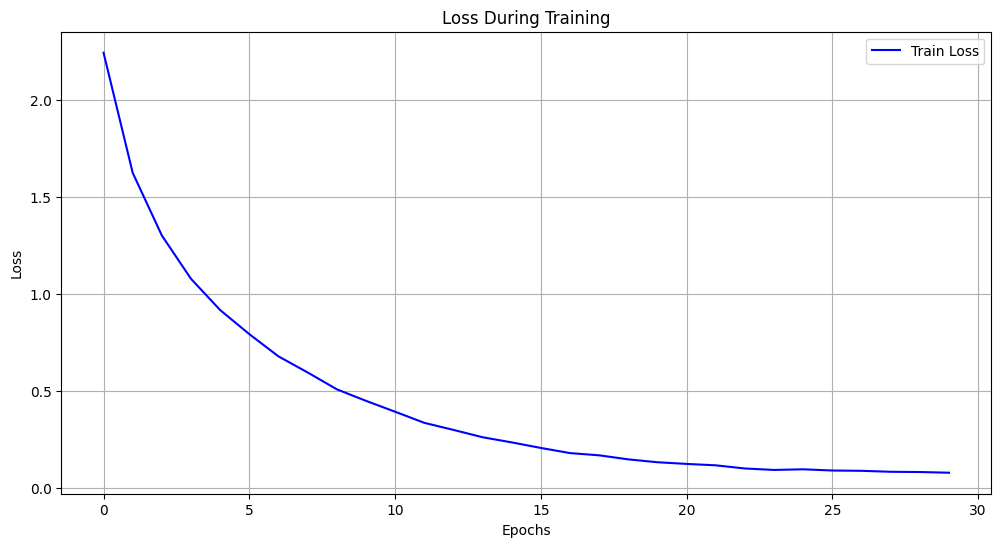

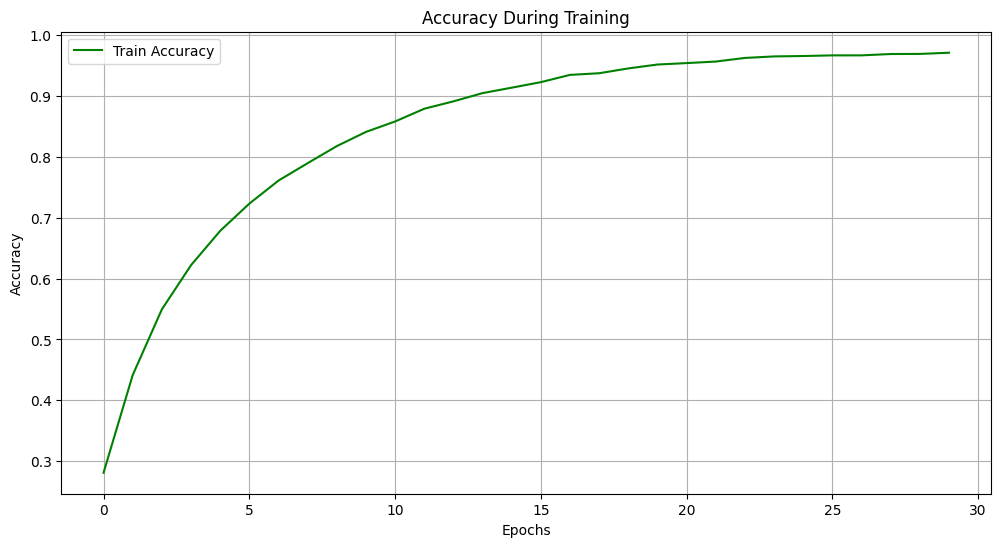

In [20]:
import matplotlib.pyplot as plt

# Lấy giá trị loss và accuracy từ history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Vẽ biểu đồ accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Train Accuracy', color='green')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [21]:
## TESTING

loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {accuracy:.6f}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 87s 766ms/step - accuracy: 0.6236 - loss: 1.5588
Test Accuracy: 0.623634


In [22]:
# Lưu mô hình vào một tệp
model.save('MobileNetV3Large_v1.h5')